In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
df=pd.read_excel("/content/Combined dataset-malocclusion.xlsx")

In [ ]:
df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})
df['RT PATTERN'] = df['RT PATTERN'].map({'L': 0, 'W': 1, 'A': 2})
df['LT PATTERN'] = df['LT PATTERN'].map({'L': 0, 'W': 1, 'A': 2})
df['Class/Group'] = df['Class/Group'].map({'Group I': 0, 'Group II': 1, 'Group III': 2})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AGE          604 non-null    int64 
 1   GENDER       604 non-null    int64 
 2   RT PATTERN   604 non-null    int64 
 3   RT FRC       604 non-null    int64 
 4   LT PATTERN   604 non-null    int64 
 5   LT FRC       604 non-null    object
 6   Class/Group  604 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 33.2+ KB


In [ ]:
bad_rows = df[pd.to_numeric(df['LT FRC'], errors='coerce').isna() & df['LT FRC'].notna()]

print(bad_rows)

     AGE  GENDER  RT PATTERN  RT FRC  LT PATTERN  \
229   21       0           1       0           1   

                                                LT FRC  Class/Group  
229  ''''''''''''''''''''''''''''''''''''''''''''''...            1  


In [ ]:
bad_values = df['LT FRC'][pd.to_numeric(df['LT FRC'], errors='coerce').isna()].unique()
print(bad_values)

["'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''"]


In [ ]:
# Drop the row where 'LT FRC' is not numeric
df = df[pd.to_numeric(df['LT FRC'], errors='coerce').notna()]


In [ ]:
df['LT FRC'] = pd.to_numeric(df['LT FRC'], errors='coerce')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 603 entries, 0 to 603
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AGE          603 non-null    int64
 1   GENDER       603 non-null    int64
 2   RT PATTERN   603 non-null    int64
 3   RT FRC       603 non-null    int64
 4   LT PATTERN   603 non-null    int64
 5   LT FRC       603 non-null    int64
 6   Class/Group  603 non-null    int64
dtypes: int64(7)
memory usage: 37.7 KB


In [ ]:
input=df.drop(['Class/Group'],axis=1)
output=df['Class/Group']

In [ ]:
xtr,xte,ytr,yte=train_test_split(input,output,test_size=0.2,random_state=42)

MLP Accuracy: 0.48760330578512395


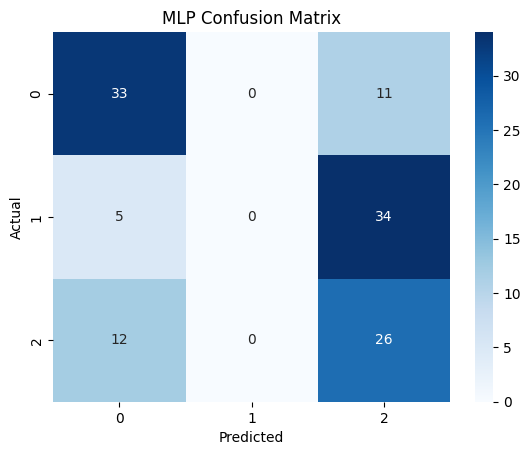

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70        44
           1       0.00      0.00      0.00        39
           2       0.37      0.68      0.48        38

    accuracy                           0.49       121
   macro avg       0.34      0.48      0.39       121
weighted avg       0.36      0.49      0.41       121



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                    learning_rate_init=0.001, max_iter=500, random_state=42, early_stopping=True)

mlp.fit(xtr, ytr)

y_pred = mlp.predict(xte)

print("MLP Accuracy:", accuracy_score(yte, y_pred))

cm = confusion_matrix(yte, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:\n", classification_report(yte, y_pred))


In [ ]:
mlp1 = MLPClassifier(max_iter=1000, random_state=42, early_stopping=True)

# Grid Search parameter grid
param_grid = {
    "hidden_layer_sizes": [(32,), (64,), (64,32), (128,64)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate_init": [0.001, 0.01, 0.05]
}

grid = GridSearchCV(mlp1, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(xtr, ytr)

print("Best GridSearch Params:", grid.best_params_)
best_grid_model = grid.best_estimator_

print("Best GridSearch Accuracy:", grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best GridSearch Params: {'activation': 'tanh', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'solver': 'sgd'}
Best GridSearch Accuracy: 0.543664089347079


In [ ]:
param_dist = {
    "hidden_layer_sizes": [(np.random.randint(32,128), np.random.randint(16,64)) for _ in range(10)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate_init": np.linspace(0.0005, 0.05, 10)
}

random_search = RandomizedSearchCV(mlp1, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring="accuracy",
                                   n_jobs=-1, verbose=1, random_state=42)
random_search.fit(xtr, ytr)

print("Best RandomSearch Params:", random_search.best_params_)
best_random_model = random_search.best_estimator_

print("Best RandomSearch Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RandomSearch Params: {'solver': 'sgd', 'learning_rate_init': np.float64(0.0335), 'hidden_layer_sizes': (127, 34), 'activation': 'relu'}
Best RandomSearch Accuracy: 0.545811855670103
